Homework: Search Evaluation
In this homework, we will evaluate the results of vector search.

Installation Process/How to Use this notebook:
``uv init``

``uv sync``

For Required libraries: please see pyproject.toml (``uv sync`` will install all the libraries used in this notebook)

Evaluation data:

For this homework, we will use the same dataset we generated in the videos.

Let's get them:

In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
ground_truth = df_ground_truth.to_dict(orient='records')

In [7]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'id': '1f6520ca'}

In [9]:
len(documents), len(ground_truth)

(948, 4627)

In [10]:
ground_truth[1]

{'question': 'How can I get the course schedule?',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

Here, documents contains the documents from the FAQ database with unique IDs, and ground_truth contains generated question-answer pairs.

Also, we will need the code for evaluating retrieval:

In [2]:
from tqdm.auto import tqdm

def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

c:\DEV\DATATALKSCLUB-LLM-BOOTCAMP\03-evaluation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Q1. Minsearch text

Now let's evaluate our usual minsearch approach, indexing documents with:

``text_fields=["question", "section", "text"],``
``keyword_fields=["course", "id"]``

but tweak the parameters for search. Let's use the following boosting params:

``boost = {'question': 1.5, 'section': 0.1}``

In [3]:
import minsearch

index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course", "id"]
)

index.fit(documents)

In [4]:
def minsearch_search(query, course):
    boost = {'question': 1.5, 'section': 0.1}

    results = index.search(
        query=query,
        filter_dict={'course': course},
        boost_dict=boost,
        num_results=5
    )

    return results

Question: What's the hitrate for this approach?

Answer: 0.84

In [23]:
evaluate(ground_truth, lambda q: minsearch_search(q['question'], q['course']))

100%|██████████| 4627/4627 [00:19<00:00, 242.42it/s]


{'hit_rate': 0.848714069591528, 'mrr': 0.7288235717887772}

Embeddings

The latest version of minsearch also supports vector search. We will use it:
``from minsearch import VectorSearch``

We will also use TF-IDF and Singular Value Decomposition to create embeddings from texts. You can refer to our "Create Your Own Search Engine" workshop if you want to know more about it.

In [5]:
from minsearch import VectorSearch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

Let's create embeddings for the "question" field:

In [6]:
texts = []

for doc in documents:
    t = doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

Q2. Vector search for question

Now let's index these embeddings with minsearch:

In [7]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [8]:
def min_vector_search(query, course):
    query_vector = pipeline.transform([query])[0] 
    results = vindex.search(
            query_vector,
            filter_dict={'course': course},
            num_results=5
        )

    return results

Question: Evaluate this seach method. What's MRR for it?
Answer: 0.35

In [28]:
evaluate(ground_truth, lambda q: min_vector_search(q['question'], q['course']))

100%|██████████| 4627/4627 [00:10<00:00, 433.95it/s]


{'hit_rate': 0.48173762697212014, 'mrr': 0.3571284489590088}

Q3. Vector search for question and answer

We only used question in Q2. We can use both question and answer:

In [35]:
texts = []

for doc in documents:
    t = doc['question'] + ' ' + doc['text']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [36]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

Question:
Using the same pipeline (min_df=3 for TF-IDF vectorizer and n_components=128` for SVD), evaluate the performance of this approach

What's the hitrate?

Answer:

In [39]:
evaluate(ground_truth, lambda q: min_vector_search(q['question'], q['course']))

100%|██████████| 4627/4627 [00:15<00:00, 290.68it/s]


{'hit_rate': 0.8210503566025502, 'mrr': 0.6717707657949719}

Q4. Qdrant

Now let's evaluate the following settings in Qdrant:

In [9]:
from qdrant_client import QdrantClient, models

In [10]:
import fastembed

In [11]:
qdrant_client = QdrantClient("http://localhost:6333")

In [12]:
EMBEDDING_DIMENSIONALITY = 512
model_handle = "jinaai/jina-embeddings-v2-small-en"

In [13]:
qdrant_collection = "hw3_collection"

In [14]:
qdrant_client.create_collection(
    collection_name=qdrant_collection,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY, 
        distance=models.Distance.COSINE, 
        on_disk=True
    ),
)

True

In [15]:
points = []

for i, doc in enumerate(documents):
    text = doc['question'] + ' ' + doc['text']
    vector = models.Document(text=text, model=model_handle)
    point = models.PointStruct(
        id=i,
        vector=vector,
        payload=doc
    )
    points.append(point)

In [16]:
qdrant_client.upsert(
    collection_name=qdrant_collection,
    points=points
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\DEV\DATATALKSCLUB-LLM-BOOTCAMP\03-evaluation\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\usvidr03\AppData\Local\Temp\fastembed_cache\models--xenova--jina-embeddings-v2-small-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Deve

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [18]:
def min_vector_search_qdrant(question, course):
    
    course = course
    query_points = qdrant_client.query_points(
        collection_name=qdrant_collection,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        query_filter=models.Filter( 
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course)
                )
            ]
        ),
        limit=5,
        with_payload=True
    )
    
    results = []
    
    for point in query_points.points:
        results.append(point.payload)
    
    return results

Question: What's the MRR?
Answer:

In [20]:
evaluate(ground_truth, lambda q: min_vector_search_qdrant(q['question'], q['course']))

100%|██████████| 4627/4627 [01:29<00:00, 51.94it/s]


{'hit_rate': 0.9299762264966501, 'mrr': 0.8517722066133576}

Q5. Cosine simiarity

In the second part of the module, we looked at evaluating the entire RAG approach. In particular, we looked at comparing the answer generated by our system with the actual answer from the FAQ.

One of the ways of doing it is using the cosine similarity. Let's see how to calculate it.

Cosine similarity is a dot product between two normalized vectors. In geometrical sense, it's the cosine of the angle between the vectors. Look up "cosine similarity geometry" if you want to learn more about it.

For us, it means that we need two things:

First, we normalize each of the vectors
Then, compute the dot product
So, we get this:

In [32]:
import numpy as np

In [23]:
def normalize(u):
    norm = np.sqrt(u.dot(u))
    return u / norm

In [24]:
def cosine(u, v):
    u = normalize(u)
    v = normalize(v)
    return u.dot(v)

In [25]:
def cosine(u, v):
    u_norm = np.sqrt(u.dot(u))
    v_norm = np.sqrt(v.dot(v))
    return u.dot(v) / (u_norm * v_norm)

In [26]:
url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
results_url = url_prefix + 'rag_evaluation/data/results-gpt4o-mini.csv'
df_results = pd.read_csv(results_url)
results_dict = df_results.to_dict(orient='records')

In [28]:
test = results_dict[1]
test

{'answer_llm': 'You can sign up using the link provided in the course GitHub repository: [https://airtable.com/shryxwLd0COOEaqXo](https://airtable.com/shryxwLd0COOEaqXo).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Can you provide a link to sign up?',
 'course': 'machine-learning-zoomcamp'}

In [29]:
texts = []

for doc in results_dict:
    t = doc['answer_llm'] + ' ' + doc['answer_orig']  + ' ' + doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
pipeline.fit(texts)

,steps,"[('tfidfvectorizer', ...), ('truncatedsvd', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [30]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = pipeline.transform([answer_orig])[0]
    v_orig = pipeline.transform([answer_llm])[0]
    
    return cosine(v_llm,v_orig)

In [33]:
similarity = []

for record in tqdm(results_dict):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1830/1830 [00:10<00:00, 167.52it/s]


In [ ]:
df_results['cosine'] = similarity
df_results['cosine'].describe()


count    1830.000000
mean        0.841584
std         0.173737
min         0.079093
25%         0.806927
50%         0.905812
75%         0.950711
max         0.996457
Name: cosine, dtype: float64

In [38]:
import seaborn as sns

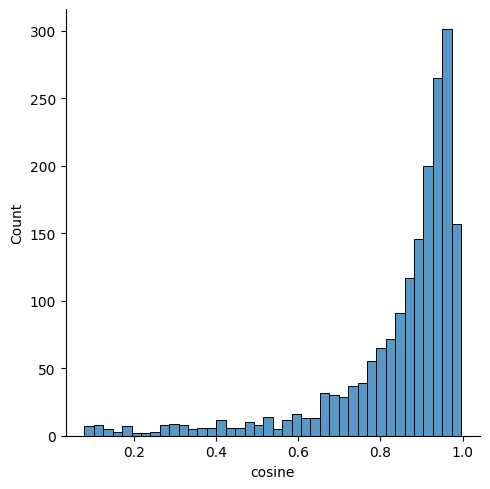

In [39]:
sns.displot(df_results['cosine'])

Q6. Rouge

And alternative way to see how two texts are similar is ROUGE.

This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.

It can give a more nuanced view of text similarity than just cosine similarity alone.

We don't need to implement it ourselves, there's a python package for it:

In [41]:
from rouge import Rouge
rouge_scorer = Rouge()

result_rouge = df_results.iloc[10]
scores = rouge_scorer.get_scores(r.answer_llm, r.answer_orig)[0]


{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

In [42]:
result_rouge

answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
cosine                                                  0.942857
Name: 10, dtype: object

In [43]:
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

In [44]:
scores['rouge-1']['f']

0.45454544954545456

In [50]:
def compute_rouge(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    return rouge_scorer.get_scores(answer_llm, answer_orig)[0]['rouge-1']['f']

In [51]:
rouge_scores = []

for record in tqdm(results_dict):
    rouge = compute_rouge(record)
    rouge_scores.append(rouge)

100%|██████████| 1830/1830 [00:09<00:00, 186.22it/s]


In [52]:
df_results['f1_rouge_score'] = rouge_scores
df_results['f1_rouge_score'].describe()

count    1830.000000
mean        0.351695
std         0.158905
min         0.000000
25%         0.238887
50%         0.356300
75%         0.460133
max         0.950000
Name: f1_rouge_score, dtype: float64